In [1]:
import numpy as np
# so it updates in main
def gen_coords_mult(re_runs,disk_radius: float, num_charges: int):
    # generates a 2D array of randomised polar coordinates distributing the charge around the disk
    polar_arr = np.random.rand(re_runs,2, num_charges) * \
        np.array((disk_radius, 2*np.pi))[..., np.newaxis]
    angle = polar_arr[:,1]
    # computes the xy coordinates of the charges
    xy = polar_arr[:,0, :, np.newaxis]*np.stack((np.cos(angle), np.sin(angle)), axis = -1)
    return xy

def Choose_Charge_mult(coords, delta, disk_radius):
    re_runs = coords.shape[0]
    num_charges = coords.shape[1]
    # gets a random charge index
    index = np.random.randint(0, num_charges,size = re_runs)
    # extracts the singular charge data
    charge_coord = coords[np.arange(re_runs),index].copy()
    move = delta*np.random.uniform(-1, 1, size=charge_coord.shape)
    charge_coord += move
    in_bounds = np.where(np.linalg.norm(charge_coord, axis=-1) > disk_radius)
    while charge_coord[in_bounds].shape[0] > 0:
        index[in_bounds] = np.random.randint(0, num_charges,size = len(in_bounds))
        charge_coord[in_bounds] = coords[in_bounds, index[in_bounds]]
        charge_coord[in_bounds] += delta*np.random.uniform(-1, 1, size=charge_coord[in_bounds].shape)
        in_bounds = np.where(np.linalg.norm(charge_coord, axis=-1) > disk_radius)
    temp = np.empty(coords.shape)
    temp[np.arange(re_runs),index] = charge_coord
    return temp

def calc_energy_mult(coords, charge=1):
    # this is unlikely to be a bottleneck so halving the computation time here probably isn't necessary
    vect_diff = vector_difference_mult(coords)
    print('vect_diff',np.where(vect_diff == 0))
    # find the indices
    i, j, k = np.indices(vect_diff.shape)
    
    # takes the upper triangular values removing double counts
    distances = vect_diff.reshape(vect_diff.shape[0], -1)
    print('distances', np.where(distances == 0))
    print(np.where(distances == 0)[0].shape)
    try:
        print(distances[np.where(distances == 0)[0][0,np.newaxis]])
    except:
        pass
    return (charge**2) * np.sum(1/distances, axis = -1)

def vector_difference_mult(charge_coords):
    # normally the dims will be 2 but could extend to higher dimensions
    re_runs, charges, dims = charge_coords.shape
    template = np.empty((re_runs, charges,charges-1, dims))
    # basic loop
    for i in range(charges):
        template[:,i] = np.delete(charge_coords,i,1)
    # print(template)
    subtraction = np.expand_dims(charge_coords,2) - template
    # returns an array of shape (no. of charges, dimensions)
    return np.linalg.norm(subtraction,axis=-1)

def Accept_change(coords_chg, coords, temperature):
    orig_energy = calc_energy_mult(coords)
    new_energy = calc_energy_mult(coords_chg)
    energy_diff = new_energy - orig_energy        
    temp_arr = np.empty(coords.shape)
    indexes = np.where(energy_diff < 0)
    temp_arr[indexes] = coords_chg[indexes]
    index_energ = np.where(energy_diff > 0)[0]
    test = np.random.rand(energy_diff.shape[0])
    indexes = np.where(test[index_energ] < np.exp(-energy_diff[index_energ]/temperature))
    temp_arr[indexes] = coords_chg[indexes]
    indexes = np.where(test[index_energ] > np.exp(-energy_diff[index_energ]/temperature))
    temp_arr[indexes] = coords[indexes]
    return temp_arr, calc_energy_mult(temp_arr)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from BaseFuncs import Single_pass as SP
from BaseFuncs import Mult_pass as MP
runs = 5; disk_radius = 100; num_charges = 3; charge_movements = 10; delta = 5; temp =360
charges = MP.gen_coords(runs, disk_radius, num_charges)
test = MP.vector_difference(charges)
k = np.indices(test.shape)

print(np.expand_dims(charges,2))


[[[[ -63.91369287  -20.26884463]
   [ -84.36885506   80.70854062]]

  [[  63.91369287   20.26884463]
   [ -20.45516219  100.97738525]]

  [[  84.36885506  -80.70854062]
   [  20.45516219 -100.97738525]]]


 [[[ -19.39516774    4.47673276]
   [ -49.68106313   61.1514778 ]]

  [[  19.39516774   -4.47673276]
   [ -30.28589539   56.67474503]]

  [[  49.68106313  -61.1514778 ]
   [  30.28589539  -56.67474503]]]


 [[[  -1.77363124   -9.03984934]
   [  -6.10786318   35.26622859]]

  [[   1.77363124    9.03984934]
   [  -4.33423194   44.30607793]]

  [[   6.10786318  -35.26622859]
   [   4.33423194  -44.30607793]]]


 [[[ -98.21298269    6.64830513]
   [ -48.98174943  117.65087907]]

  [[  98.21298269   -6.64830513]
   [  49.23123326  111.00257394]]

  [[  48.98174943 -117.65087907]
   [ -49.23123326 -111.00257394]]]


 [[[  23.17140208  -29.06733373]
   [  16.18665367  -20.44415629]]

  [[ -23.17140208   29.06733373]
   [  -6.98474842    8.62317744]]

  [[ -16.18665367   20.44415629]
   [   

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from BaseFuncs import Single_pass as SP
from BaseFuncs import Mult_pass as MP

runs = 5; disk_radius = 100; num_charges = 2; charge_movements = 10; delta = 5; temp =360
re_runs = runs
angles = np.linspace(0, 2*np.pi, 100)
x = disk_radius*np.cos(angles)
y = disk_radius*np.sin(angles)
charges = MP.gen_coords(runs, disk_radius, num_charges)
temp_coords = MP.Choose_Charge(charges, delta, disk_radius)
updated_coords, energy = MP.Accept_change(temp_coords, charges, temp)

energy_lst = energy[:,np.newaxis]
iterations = 1

# for j in range(charge_movements):
#             # each loop here moves a charge.
#     temp_coords = MP.Choose_Charge(updated_coords, delta, disk_radius)
#     updated_coords, energy = MP.Accept_change(
#         temp_coords, updated_coords, temp)
#     energy_lst = np.append(energy_lst, energy[:,np.newaxis], axis = -1)
#     iterations +=1
#     fig , axs = plt.subplots(re_runs, 2, figsize = (10,5*re_runs))
    
    
# coords = updated_coords
# energies = energy_lst
# fig , axs = plt.subplots(re_runs, 2, figsize = (10,5*re_runs))
# for index in range(re_runs):
#     ax = axs[index , 0]
#     ax2 = axs[index, 1]
#     ax.scatter(coords[index,:,0], coords[index,:,1], s = 3, c = 'orange')
#     ax.plot(x,y, linewidth = 1)
    
#     ax.set_title('{} with energy {}'.format(num_charges, np.round(energies[index,-1],8)))
#     ax.set(xlabel = 'x Position/ AU', ylabel = 'y Position/ AU')
#     ax2.plot(np.arange(iterations), energies[index])
#     ax2.set_title('Energy After N Iterations')
#     ax2.set_xlabel('Iterations')
#     ax2.set_ylabel('Energy/ AU')


old [[[-93.18196363 -14.52570525]
  [ -9.34889187   1.30694197]]

 [[-24.56410589 -53.87431233]
  [ 17.80896588 -87.68096721]]

 [[-19.37278713  -5.78048548]
  [-20.74832369  11.97115227]]

 [[ 62.65808338  66.74084174]
  [-85.87955867   8.12587282]]

 [[-16.69023518  -1.04224073]
  [ 94.51991984 -25.8238575 ]]]
new [[[-92.7707578  -18.73598879]
  [ -9.34889187   1.30694197]]

 [[-24.56410589 -53.87431233]
  [ 16.84722828 -83.15105581]]

 [[-19.37278713  -5.78048548]
  [-19.02756645  11.62026016]]

 [[ 62.65808338  66.74084174]
  [-84.71630763   7.49655389]]

 [[-19.97307492  -2.16522142]
  [ 94.51991984 -25.8238575 ]]]
 lower energy [0 4]
after lower energies [[[-92.7707578  -18.73598879]
  [ -9.34889187   1.30694197]]

 [[  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.        ]]

 [[-19.97307492  -2.16522142]
  [ 94.51991984 -25.8238575 ]]]
 higher energy [1 2 3

Text(0.5, 0, 'r/AU')

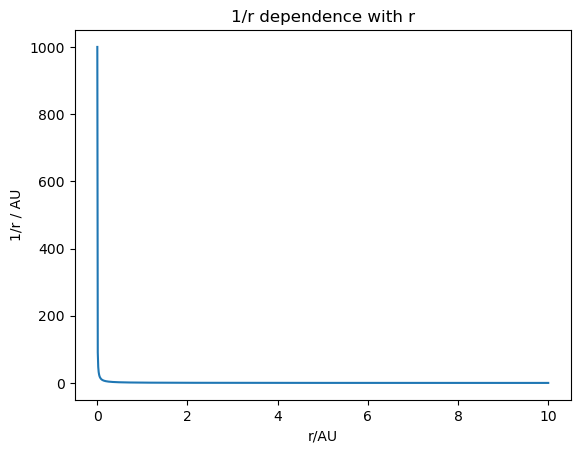

In [3]:
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(1e-3, 10, 1000)
y = np.power(x, -1)
plt.plot(x,y)
plt.title('1/r dependence with r')
plt.ylabel('1/r / AU')
plt.xlabel('r/AU')

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def func(charges_lst):
    values_lst = np.zeros(2)    
    final_vals = np.zeros(5)
    for k in range(len(charges_lst)):
        for j in range(len(charges_lst[k])-1):
            for i in range(len(charges_lst[k,j])):
                values_lst[i] = (charges_lst[k,j,i] - charges_lst[k,j+1,i])**2
            
            for i in range(len(values_lst)):
                final_vals[k] = final_vals[k] + values_lst[i]
        
    
    return abs(1/final_vals**0.5)



charges_lst = np.random.uniform(-5,5,size = (5,7, 2))

# print(charges_lst)
# plt.figure()
# plt.scatter([charges_lst[i][0] for i in range(len(charges_lst))], [charges_lst[i][1] for i in range(len(charges_lst))])

print(func(charges_lst))

[0.12841118 0.06279311 0.07793336 0.05529896 0.08228529]
